In [27]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

%matplotlib inline

import lightgbm as lgb
from lightgbm import early_stopping
from sklearn import preprocessing, metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 1. 데이터셋 load

In [2]:
train_path = '/Volumes/Expansion/google_analytics_customer/train.csv'
test_path = '/Volumes/Expansion/google_analytics_customer/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_20390/1646842768.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path)
/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_20390/1646842768.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_path)


# 2. 데이터 전처리

## 1) json형 값을 갖는 컬럼 펼치기

In [3]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'} # Important!!
                    )

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])  # ✅ 최신 방식 적용
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [4]:
train_df = load_df('/Volumes/Expansion/google_analytics_customer/train.csv')
test_df = load_df('/Volumes/Expansion/google_analytics_customer/test.csv')

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


## 2) 컬럼 사전 제거

### (1) Constant value를 갖는 컬럼
- 모든 행이 같은 값을 가지고 있는 컬럼 조회

In [5]:
df = train_df.copy()

const_cols = [c for c in df.columns if df[c].nunique(dropna=False)==1]

const_cols

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

### (2) train_df에 있지만, test_df에 없는 컬럼 조회
- 존재할 시 train_df에서 제거 (target : totals.transactionRevenue는 제외)

In [6]:
diff_cols = list(set(train_df.columns) - set(test_df.columns))

diff_cols

['totals.transactionRevenue', 'trafficSource.campaignCode']

### (3) `const_cols`, `trafficSource.campaignCode` + `sessionId` 제거

In [7]:
cols_to_drop = const_cols + ['sessionId']

df = df.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

In [8]:
print("Train DataFrame Length : ", len(df.columns))
print("Test DataFrame Length : ", len(test_df.columns))
print("두 데이터프레임의 컬럼 차이 : ", set(df.columns)-set(test_df.columns))

Train DataFrame Length :  34
Test DataFrame Length :  33
두 데이터프레임의 컬럼 차이 :  {'totals.transactionRevenue'}


## 3) 결측치 처리
- totals.transactionRevenue 결측치 처리 : NaN -> 0 대체
- target 추출

In [9]:
df['totals.transactionRevenue'].fillna(0, inplace=True)
train_y = df['totals.transactionRevenue'].values

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_20390/1196167568.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['totals.transactionRevenue'].fillna(0, inplace=True)


## 4) 범주형 데이터 처리, 상관관계 분석

- 범주형 데이터 정의

In [10]:
cat_cols = ['channelGrouping', 'device.browser', 'device.deviceCategory',
            'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent',
            'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain',
            'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adContent',
            'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId',
            'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot',
            'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium',
            'trafficSource.referralPath', 'trafficSource.source',
            'trafficSource.adwordsClickInfo.isVideoAd','trafficSource.isTrueDirect']

### (1) 상관관계 분석 및 시각화
- 범주형 데이터 label encoding
- target(totals.transactionRevenue)와 타 Feature들 간의 상관관계 분석 및 시각화

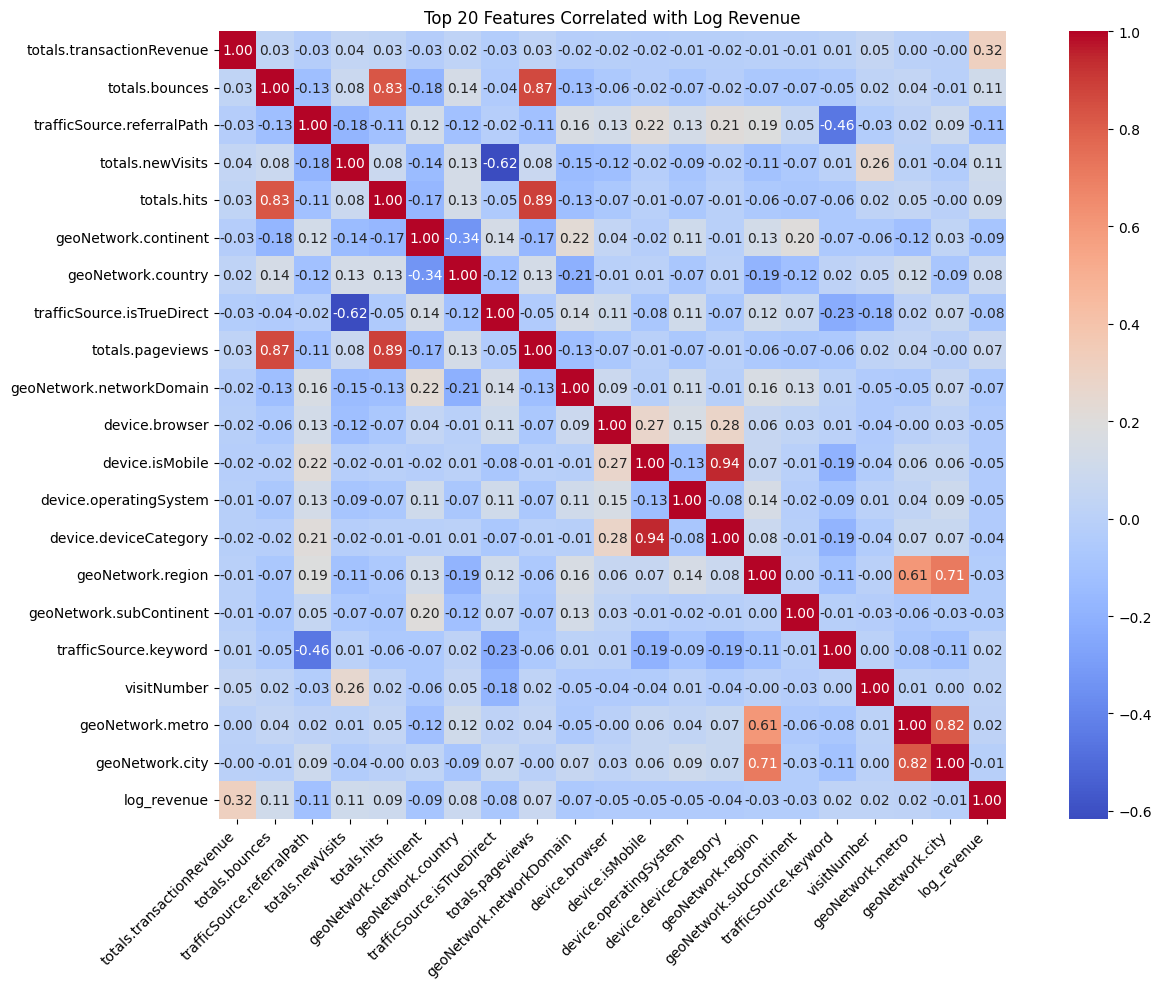

In [ ]:

# 1. 로그 스케일로 target 생성
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype(float)
df['log_revenue'] = np.log1p(df['totals.transactionRevenue'])

# 2. 수치형 + 범주형 포함한 전체 컬럼 목록
cat_cols = df.select_dtypes(include='object').columns.tolist()

# 범주형 컬럼은 Label Encoding
for col in cat_cols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df[col].values.astype('str')) + list(test_df[col].values.astype('str')))

    df[col] = lbl.transform(list(df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

# 3. 상관계수 분석
corr_matrix = df.corr()
target_corr = corr_matrix['log_revenue'].drop('log_revenue').sort_values(ascending=False)

# 4. 히트맵 시각화 (상위 상관관계 20개만)
top_corr_cols = target_corr.abs().sort_values(ascending=False).head(20).index.tolist()
top_corr_matrix = df[top_corr_cols + ['log_revenue']].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Top 20 Features Correlated with Log Revenue")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### (2) 모델 훈련을 위한 데이터 split

- target 로그 변환

In [18]:
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype(float)
df['log_revenue'] = np.log1p(df['totals.transactionRevenue'])

- 상관관계 분석 결과 임계값을 넘지 못하는 관계성을 지닌 컬럼 제거

In [65]:
# target 컬럼 설정
target = 'log_revenue'

# 임계값 설정
threshold = 0.04

# 상관계수 절댓값 기준으로 유의미한 컬럼만 추출
selected_features = target_corr[abs(target_corr) >= threshold].index.tolist()

print(f"선택된 feature 수: {len(selected_features)}")
print("선택된 컬럼 목록:", selected_features)

# 선택된 feature + target만 포함한 데이터프레임으로 축소
reduced_df = df[selected_features + [target]]

train_final = reduced_df.copy()
test_final = test_df[[col for col in selected_features if col in test_df.columns]].copy()

선택된 feature 수: 14
선택된 컬럼 목록: ['totals.transactionRevenue', 'totals.bounces', 'totals.newVisits', 'totals.hits', 'geoNetwork.country', 'totals.pageviews', 'device.deviceCategory', 'device.operatingSystem', 'device.isMobile', 'device.browser', 'geoNetwork.networkDomain', 'trafficSource.isTrueDirect', 'geoNetwork.continent', 'trafficSource.referralPath']


- train, valid, test split

In [66]:
train_y = train_final['log_revenue'].values
train_X = train_final.drop(['log_revenue', 'totals.transactionRevenue'], axis=1)
test_X = test_final.copy()

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}")

train_X shape: (903653, 13)
train_y shape: (903653,)
test_X shape: (804684, 13)


In [67]:
# 80% train / 20% valid split
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, X_valid: {X_valid.shape}")

X_train: (722922, 13), X_valid: (180731, 13)


# 3. 모델 훈련

### (1) LightGBM 모델 훈련

In [68]:
# 훈련 함수 정의
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression", # 회귀
        "metric" : "rmse",          # 평가지표
        "num_leaves" : 30,          # 트리 복잡도
        "min_child_samples" : 100,  # 과적합 방지를 위한 최소 데이터 수
        "learning_rate" : 0.1,      # 학습률
        "bagging_fraction" : 0.7,   # 샘플링 비율 (row)
        "feature_fraction" : 0.5,   # 피처 샘플링 비율 (column)
        "bagging_frequency" : 5,    # 5라운드마다 bagging 수행
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    # 데이터셋
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    # 모델 훈련 (1000라운드 훈련, 검증 성능이 100번 안 좋아지면 중단)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], callbacks=[early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)])
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(X_train, y_train, X_valid, y_valid, test_X)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.66575
[200]	valid_0's rmse: 1.65753
[300]	valid_0's rmse: 1.65542
[400]	valid_0's rmse: 1.65453
[500]	valid_0's rmse: 1.65385
[600]	valid_0's rmse: 1.65399
Early stopping, best iteration is:
[528]	valid_0's rmse: 1.65368


### (2) Metrics 확인

In [62]:
# 음수 예측 제거
pred_val[pred_val < 0] = 0

# 원본 df의 index와 X_valid의 index를 이용해 fullVisitorId 가져오기
val_pred_df = pd.DataFrame()
val_pred_df["fullVisitorId"] = df.iloc[X_valid.index]["fullVisitorId"].values
val_pred_df["transactionRevenue"] = df.iloc[X_valid.index]["totals.transactionRevenue"].astype(float).values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)  # log scale → 원래 scale

# 사용자 단위로 집계
val_pred_df = val_pred_df.groupby("fullVisitorId")[["transactionRevenue", "PredictedRevenue"]].sum().reset_index()

# RMSLE 계산 (로그 변환 후)
rmsle = np.sqrt(metrics.mean_squared_error(
    np.log1p(val_pred_df["transactionRevenue"].values),
    np.log1p(val_pred_df["PredictedRevenue"].values)
))
print("RMSLE:", rmsle)

RMSLE: 1.6333170519864602


### (3) 예측 결과 시각화

RMSLE : 1.6333170519864602
RMSE  : 64203068.0800162
MAE   : 1871086.294815688
R2    : 0.3571628616210958


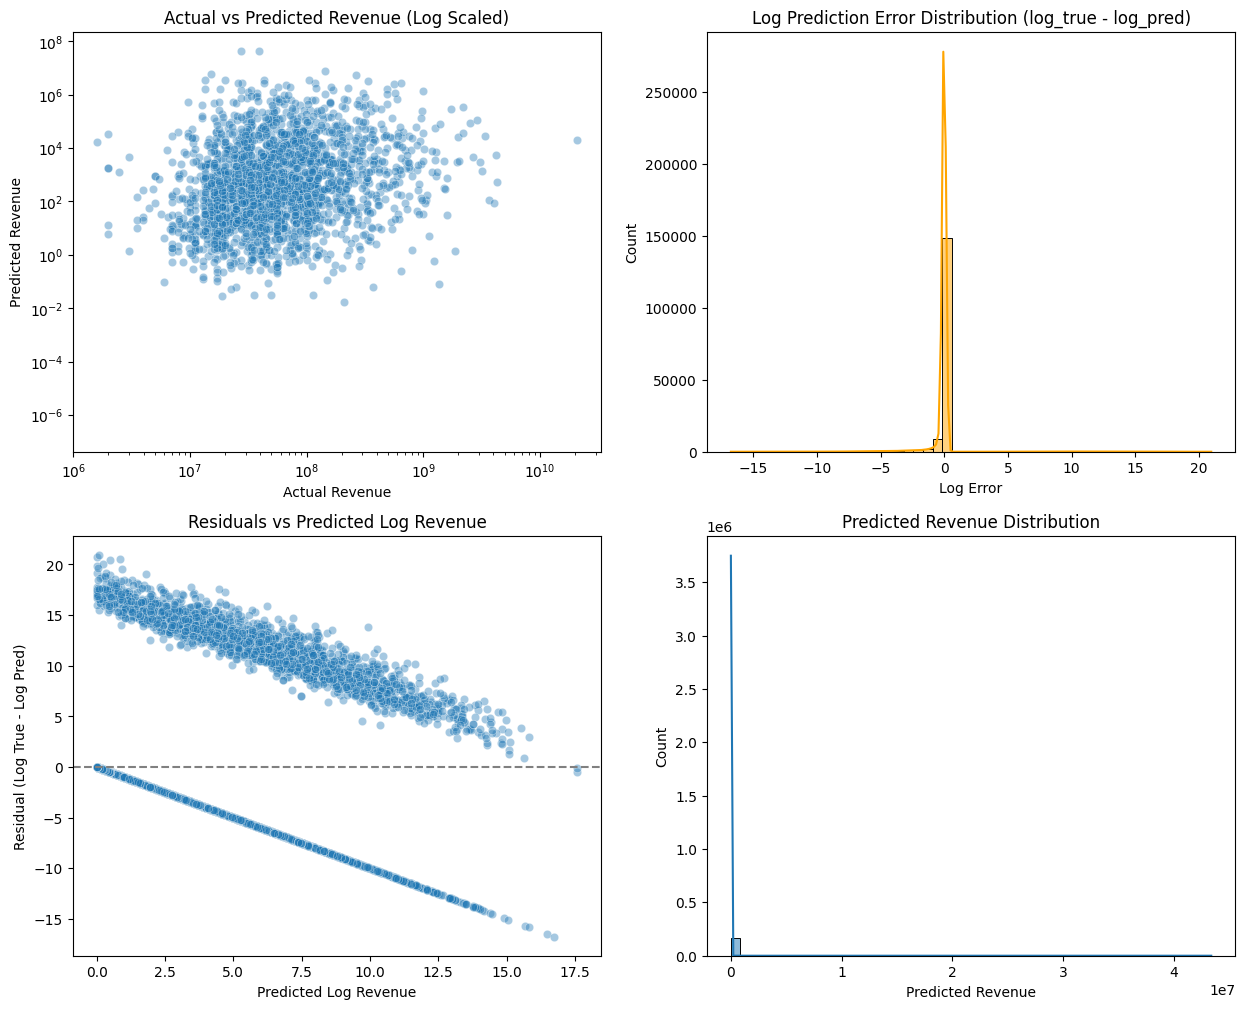

In [63]:
# 로그 예측값 복원
val_pred_df['log_true'] = np.log1p(val_pred_df['transactionRevenue'])
val_pred_df['log_pred'] = np.log1p(val_pred_df['PredictedRevenue'])
val_pred_df['error'] = val_pred_df['log_true'] - val_pred_df['log_pred']

# 평가지표 출력
print('RMSLE :', np.sqrt(metrics.mean_squared_error(val_pred_df['log_true'], val_pred_df['log_pred'])))
print('RMSE  :', np.sqrt(metrics.mean_squared_error(val_pred_df['transactionRevenue'], val_pred_df['PredictedRevenue'])))
print('MAE   :', metrics.mean_absolute_error(val_pred_df['transactionRevenue'], val_pred_df['PredictedRevenue']))
print('R2    :', metrics.r2_score(val_pred_df['log_true'], val_pred_df['log_pred']))

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

## 1. 실제 vs 예측 산점도
sns.scatterplot(data=val_pred_df, x='transactionRevenue', y='PredictedRevenue', ax=axes[0,0], alpha=0.4)
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].set_title('Actual vs Predicted Revenue (Log Scaled)')
axes[0, 0].set_xlabel('Actual Revenue')
axes[0, 0].set_ylabel('Predicted Revenue')

## 2. 로그 에러 분포
sns.histplot(val_pred_df["error"], bins=50, kde=True, ax=axes[0, 1], color="orange")
axes[0, 1].set_title("Log Prediction Error Distribution (log_true - log_pred)")
axes[0, 1].set_xlabel("Log Error")
axes[0, 1].set_ylabel("Count")

## 3. 잔차(residuals) vs 예측값
sns.scatterplot(x="log_pred", y="error", data=val_pred_df, ax=axes[1, 0], alpha=0.4)
axes[1, 0].axhline(0, linestyle="--", color="gray")
axes[1, 0].set_title("Residuals vs Predicted Log Revenue")
axes[1, 0].set_xlabel("Predicted Log Revenue")
axes[1, 0].set_ylabel("Residual (Log True - Log Pred)")

## 4. 예측값 분포
sns.histplot(val_pred_df["PredictedRevenue"], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Predicted Revenue Distribution")
axes[1, 1].set_xlabel("Predicted Revenue")
axes[1, 1].set_ylabel("Count")

plt.show()